## Abstract

In this blog post, we extend our previous implementation of standard logistic regression to a kernelized setting, allowing our model to detect nonlinear decision boundaries.
Specifically, we implement a sparse kernel machine using the $\ell_1$ regulizer to ensure that the vast majority of $\mathbf{a}$'s entries are indistinguishable from zero.
After implementing sparse kernelized logistic regression, we perform a few experiments to investigate the properties of the algorithm.
We test different values of $\lambda$ to investigate how this parameter impacts the number of points indistinguishable from zero, we test different values of $\gamma$ to reveal how this parameter impacts the wiggliness of our decision boundary, and we test the model on nonlinear data from `scikit-learn`'s `make_moons()` function to illustrate that the model is robust to nonlinear patterns.
Finally, we fit a model with a large $\gamma$-value and compute ROC curves to reveal how this parameter may lead to overfitting.
To see my implementation of sparse kernelized logistic regression, please visit [`sparse_kernel_logistic.py`](sparse_kernel_logistic.py).


## Generating Training Data

First, we import the packages we will need for this assignment.

In [1]:
# import packages
%load_ext autoreload
%autoreload 2
from sparse_kernel_logistic import KernelLogisticRegression, GradientDescentOptimizer
import torch 
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

Next, we generate the data that we will use to train our model.
Thank you to Professor Chodrow for providing the functions for generating and visualizing training data.

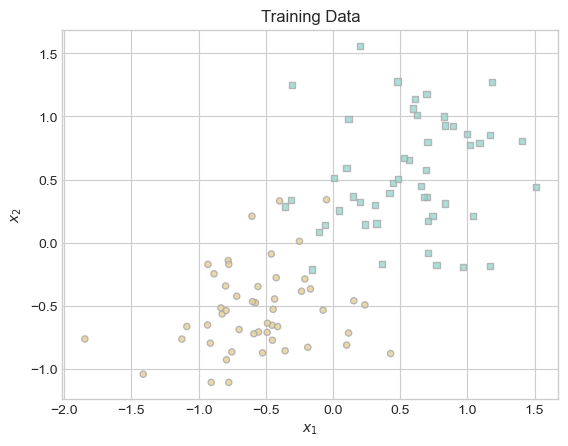

In [2]:
# define function for creating classification data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y

# define function for plotting classification data
def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# set seed
torch.manual_seed(1)

# create classification data
X, y = classification_data(n_points = 100, noise = 0.4)

# plot classification data
fig, ax = plt.subplots(1, 1)
plot_classification_data(X, y, ax)
plt.title("Training Data");

## Fitting Our First Model

With our training data in hand and our implementation of kernelized logistic regression in [sparse_kernel_logistic.py](sparse_kernel_logistic.py), we are ready to fit our first model!
In our first model, we are paying particular attention to whether our output matches our expected output, hoping to confirm that our implementation is adequate and bug-free.

In this model and for the remainder of this blog post, we will use the Gaussian radial basis function (RBF) kernel.

In [3]:
# define kernel
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

# set seed
torch.manual_seed(1)

# create kernel logistic regression model
KR = KernelLogisticRegression(X, rbf_kernel, lam = .1, gamma = 0.1)
opt = GradientDescentOptimizer(KR)

# fit model
for i in range(100000):
    # update model
    opt.step(X, y, alpha = 0.0001)

In sparse kernelized logistic regression, the $\ell_1$ norm is used to make the model sparse -- that is, to make most entries of $\mathbf{a}$ equal to zero.
Let us confirm that must of our entries for $\mathbf{a}$ are indeed close to zero.

In [4]:
# compute proportion of coefficients distinguishable from zero
(1.0*(torch.abs(KR.a) > 0.001)).mean()

tensor(0.0500)

Success! Finally, let us confirm that our model is scoring points appropriately.
We will not actually implement a decision threshold in this blog post, but the important point here is whether the scores of one class tend to be different from the scores of the other class.

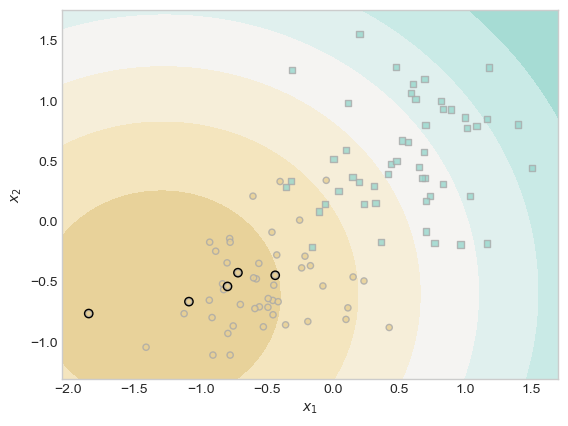

In [5]:
# plot results using Professor Chodrow's provided code
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG_r", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black");

In our output, there is a dark brown ring around most of the brown points in the lower left side of the plot.
Expanding outwards, each subsequent concentric ring is less and less likely to contain brown points.
These rings correspond to scores of that region of the graph, so you can imagine the model picking an appropriate score cutoff that serves as a pretty accurate decision threshold.

## Basic Experiments

In this section, we tinker with our parameter values in order to see how they impact the output of our model.

### Experiment 1: Adjusting $\lambda$

In our first experiment, we leave all of the parameters the same as our initial model except for $\lambda$, which we increase from $0.1$ to $0.11$.
Recall that $\lambda$ is the coefficient of the $\ell_1$ regulizer.
As the $\ell_1$ regulizer is responsible for making $\mathbf{a}$ sparse, increasing the weight of this regularization term will have the effect of making $\mathbf{a}$ even more sparse.

In [6]:
# set seed
torch.manual_seed(1)

# create kernel logistic regression model
KR = KernelLogisticRegression(X, rbf_kernel, lam = .11, gamma = 0.1)
opt = GradientDescentOptimizer(KR)

# fit model
for i in range(100000):
    # update model
    opt.step(X, y, alpha = 0.0001)

Now that we have trained our model, let us determine how many entries of $\mathbf{a}$ are distinguishable from zero.
As before, we define distinguishable from zero to mean that a coefficient's magnitude is greater than $0.001$.

In [7]:
# calculate total points distinguishable from zero
(1.0*(torch.abs(KR.a) > 0.001)).sum()

tensor(1.)

In this case, by increasing $\lambda$ from $0.1$ to just $0.11$, our model went from having $5$ points with weights distinguishable from zero to having only $1$.

### Experiment 2: Adjusting $\gamma$

In this experiment, we use the same parameters from our initial model except for $\gamma$, which controls the bandwidth of our RBF kernel.
According to [scikit-learn](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html), this means that $\gamma$ controls how far the influence of a training point reaches.
Smaller $\gamma$-values give points influence over more space, while larger $\gamma$-values give points influence over less space.
In our first example, the shape of our score contours was very smooth.
When points have influence over a small amount of space, the model becomes more sensitive to individual points, so I suspect that a larger $\gamma$ value will result in wigglier score contours. 
To see whether this is true, I increase $\gamma$ from $0.1$ to $3$ below.

In [8]:
# set seed
torch.manual_seed(1)

# create kernel logistic regression model
KR = KernelLogisticRegression(X, rbf_kernel, lam = .1, gamma = 3)
opt = GradientDescentOptimizer(KR)

# fit model
for i in range(100000):
    # update model
    opt.step(X, y, alpha = 0.0001)

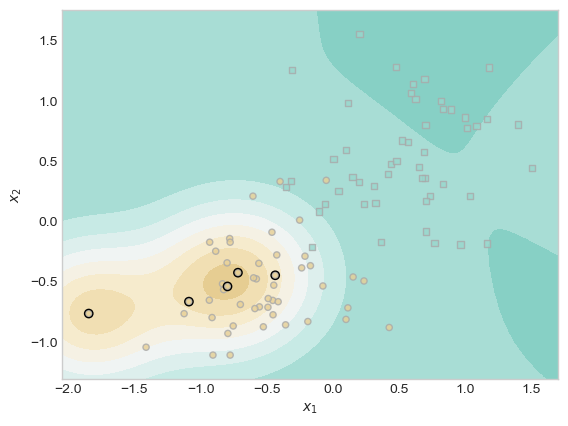

In [9]:
# plot results using Professor Chodrow's provided code
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG_r", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black");

As I anticipated, the score contours are less smooth and less circular.
In the lower left, rather than one set of concentric rings, we now have two sets.
On the right hand side, we now witness some sharper curves than those present in the concentric rings from our first model.
In this manner, our results confirm our expectations that larger values of $\gamma$ result in wigglier decision boundaries.

### Experiment 3: Detecting Nonlinear Patterns

First, let us use `scikit-learn`'s `make_moons()` function to generate data with a nonlinear pattern.

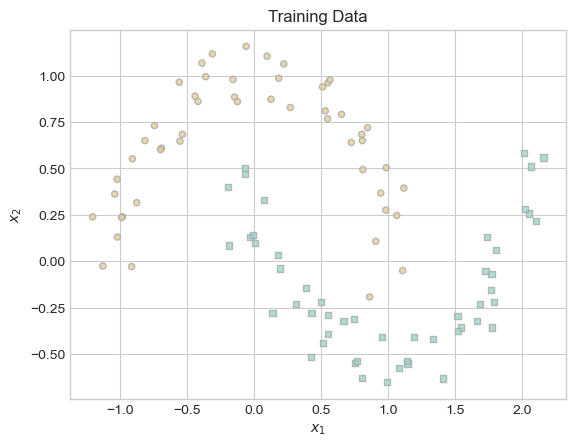

In [27]:
# set seed
torch.manual_seed(1)

# Create nonlinear training data
moons_X, moons_y = make_moons(n_samples=100, noise = 0.1)

# Convert to torch tensors
moons_X = torch.tensor(moons_X, dtype = torch.float32)
moons_y = torch.tensor(moons_y, dtype = torch.float32)

# plot data
fig, ax = plt.subplots(1, 1)
plot_classification_data(moons_X, moons_y, ax)
plt.title("Training Data");

While the pattern of this data is clear to the human eye, it is also clear that the curve separating the two classes of data is not a straight line.
Let us see whether our kernelized logistic regression model can detect this difference.

In [28]:
# create kernel logistic regression model
KR = KernelLogisticRegression(moons_X, rbf_kernel, lam = .075, gamma = 4)
opt = GradientDescentOptimizer(KR)

# fit model
for i in range(200000):
    # update model
    opt.step(moons_X, moons_y, alpha = 0.0001)

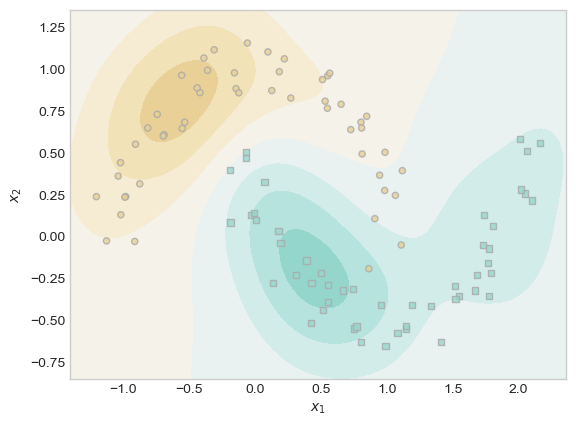

In [29]:
# show results
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(moons_X[:,0].min() - 0.2, moons_X[:,0].max() + 0.2, 101)
x2 = torch.linspace(moons_X[:,1].min() - 0.2, moons_X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(moons_X, moons_y, ax)
plt.scatter(moons_X[ix, 0],moons_X[ix, 1], facecolors = "none", edgecolors = "black");

It took me some time to discover parameter values that resulted in a relatively well-fit model, but with some tuning, it appears that kernelized logistic regression can indeed find nonlinear patterns in data such as the one above.
The model has not performed perfectly, but on the top left there is a curve that generally follows the shape of the upper moon, and on the bottom right there is a curve that generally follows the shape of the lower moon.
The most difficult region for the model to predict the correct label appears to be where one moon almost intersects the center of the other moon.
While it is not perfect, I am overall impressed by how well the model has performed.
The fact that kernelized logistic regression can find nonlinear patterns represents a substantial improvement over traditional logistic regression.

## Overfitting

In this section, we intentionally overfit a model with a poor choice of $\gamma$ in order to demonstrate the potential issues of overfitting.
First, we generate training and testing data using the same function.

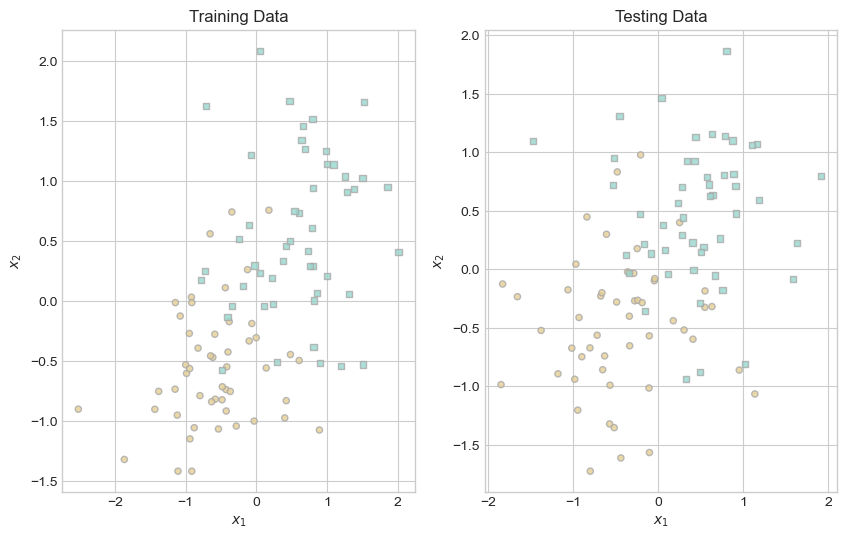

In [13]:
# set seed
torch.manual_seed(1)

# generate training data
X_train, y_train = classification_data(n_points = 100, noise = 0.6)

# generate testing data
X_test, y_test = classification_data(n_points = 100, noise = 0.6)

# show training and testing data side by side
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
plot_classification_data(X_train, y_train, ax[0])
ax[0].set_title("Training Data")
plot_classification_data(X_test, y_test, ax[1])
ax[1].set_title("Testing Data");

Because we used Professor Chodrow's `classification_data()` function for generating both datasets, we know that the training and testing data have the same underlying pattern.
By inspecting the graphs above, it is obvious that one class tends to be located in the lower left of the graph, while the other class tends to be located in the upper right.
By introducing noise into the generation of both datasets, we ensured that the two datasets are not identical.
Now that we have our data, we train our model and inspect its score contours.

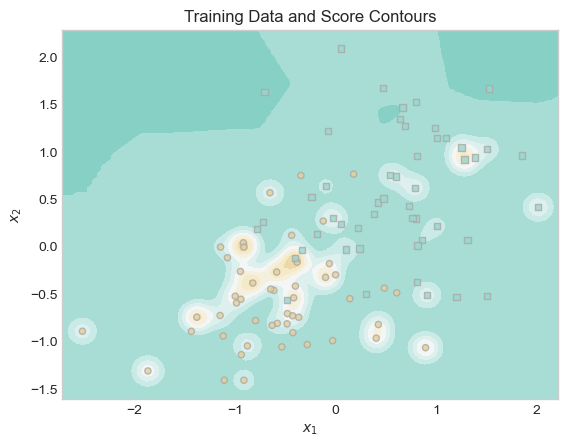

In [14]:
# train model
KR = KernelLogisticRegression(X_train, rbf_kernel, lam = .065, gamma = 50)
opt = GradientDescentOptimizer(KR)

# fit model
for i in range(100000):
    # update model
    opt.step(X_train, y_train, alpha = 0.0001)
    
# show results
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X_train[:,0].min() - 0.2, X_train[:,0].max() + 0.2, 101)
x2 = torch.linspace(X_train[:,1].min() - 0.2, X_train[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1,1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG_r", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X_train, y_train, ax)
ax.set_title("Training Data and Score Contours");

Visually, the score contours appear to reflect the individual data points relatively well.
The background is blue, with a region of brown surrounding groups of and occasionally individual brown points.
However, the underlying pattern used to generate this data is a roughly linear boundary between the upper right and lower left.
These somewhat wiggly contours may reflect the noise of our training data more than the overall pattern in the data.

Let us evaluate the performance of our model on our training data and testing data by computing ROC curves.
Thank you to Professor Chodrow for providing some code for creating ROC curves in his [lecture notes](https://www.philchodrow.prof/ml-notes/chapters/04-decision-theory.html).

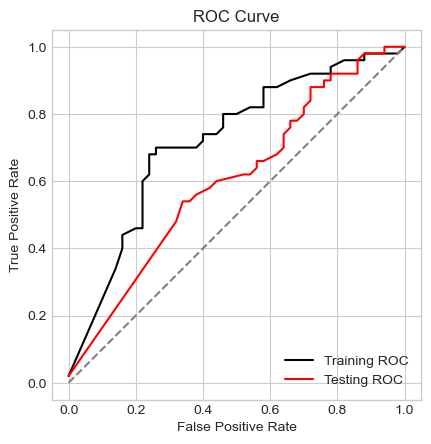

In [15]:
# roc curve training data

# store min and max scores
    # train
s_train = KR.score(X_train)
score_min_train = s_train.min()
score_max_train = s_train.max()
    # test
s_test = KR.score(X_test)
score_min_test = s_test.min()
score_max_test = s_test.max()

# create vectors for TPR and FPR
num_thresholds = 101
    #train
FPR_train = np.zeros(num_thresholds)
TPR_train = np.zeros(num_thresholds)
T_train = np.linspace(score_min_train, score_max_train, num_thresholds)
    # test
FPR_test = np.zeros(num_thresholds)
TPR_test = np.zeros(num_thresholds)
T_test = np.linspace(score_min_test, score_max_test, num_thresholds)

# calculate TPR and TNR
    # train
for i in range(num_thresholds):
    t = T_train[i]
    preds    = s_train <= t
    FPR_train[i]   = ((preds == 1) & (y_train == 0)).sum() / (y_train == 0).sum()
    TPR_train[i]   = ((preds == 1) & (y_train == 1)).sum() / (y_train == 1).sum()
    # test
for i in range(num_thresholds):
    t = T_test[i]
    preds    = s_test <= t
    FPR_test[i]   = ((preds == 1) & (y_test == 0)).sum() / (y_test == 0).sum()
    TPR_test[i]   = ((preds == 1) & (y_test == 1)).sum() / (y_test == 1).sum()

# create figure
fig, ax = plt.subplots(1, 1)

ax.plot(FPR_train, TPR_train, color = "black", label = "Training ROC")
ax.plot([0,1], [0,1], linestyle="--", color = "grey")
ax.plot(FPR_test, TPR_test, color = "red", label = "Testing ROC")
ax.set_aspect('equal')
plt.legend(loc = "lower right")
labs = ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate", title = "ROC Curve")

Recall that a perfect ROC curve reaches the top left corner of this graph with a false positive rate of 0 and a true positive rate of 1.
Because data is rarely perfect, models rarely achieve this goal.
Rather, the effectiveness of a model is represented by how close a model comes to achieving that.
In our case, the training ROC curve is substantially above and to the left of the testing ROC curve, indicating that our model does not generalize well to the testing data.
In fact, the distance between the training and testing ROC curves is roughly the same as the distance between the testing curve and the diagonal line that represents a model that randomly guesses at the classes.
In this manner, it is clear that our model performs dramatically better on our training data than on our testing data.
Because $\gamma$ is so large, the score contours reflect the noise in our data more than the underlying pattern of our data, leading our model to ineffectively generalize to new data.

## Conclusion

In this blog post, we extended our work with logistic regression to a new situation: nonlinearity.
In our prior work, we implemented standard logistic regression and performed experiments with several optimizers, including standard gradient descent, gradient descent with momentum, and Newton's method.
In this assignment, rather than searching for more efficient optimization algorithms, we implemented a kernelized model that can find a wide array of nonlinear patterns.
We performed several experiments in order to deepen our understanding of the model, discovering that larger values of $\lambda$ result in fewer training points with non-zero coefficients, larger values of $\gamma$ result in wigglier decision boundaries, and these large $\gamma$ values can often lead to overfitting.
We also illustrated that our model can find nonlinear decision boundaries by fitting our model on data created with `scikit-learn`'s `make_moons()` function.
Overall, this assignment allowed me to learn the theory behind and implementation of an intruiging variation of an otherwise familiar machine learning algorithm.